In [1]:
%load_ext autoreload
%autoreload 2

## Basic setup

In [2]:
import Concord as ccd
import scanpy as sc
import torch
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

data_dir = Path('../data/celegans_data/')
data_path = data_dir / "celegans_global_adata.h5ad"
# adata = sc.read(
#     data_path
# )
adata = sc.read(data_dir/'celegans_Dec17-2043.h5ad')

/opt/anaconda3/envs/concord/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../data/celegans_data/celegans_Dec17-2043.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [3]:
import time
from pathlib import Path
proj_name = "concord_celegans"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
file_suffix = f"{time.strftime('%b%d-%H%M')}"
seed = 0

In [4]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata = adata[adata.obs['to.filter'] == 'FALSE']

## Run Concord

In [4]:
feature_list = ccd.ul.select_features(adata, n_top_features=10000, flavor='seurat_v3')
file_suffix = f"{time.strftime('%b%d-%H%M')}"
concord_args = {
        'adata': adata,
        'input_feature': feature_list,
        'batch_size': 128,
        'latent_dim': 300,
        'encoder_dims':[1000],
        'decoder_dims':[1000],
        'augmentation_mask_prob': 0.3, 
        'clr_temperature': 0.5,
        'p_intra_knn': 0.3,
        'sampler_knn': 300,
        'min_p_intra_domain': .95,
        'n_epochs': 15,
        'domain_key': 'batch',
        'verbose': False,
        'inplace': False,
        'seed': seed,
        'device': device,
        'save_dir': save_dir
    }

Concord.utils.feature_selector - INFO - Selecting highly variable features with flavor seurat_v3...


### Concord, no decoder

In [5]:
output_key = f'Concord_{file_suffix}'
cur_ccd = ccd.Concord(use_decoder=False, **concord_args)
cur_ccd.encode_adata(input_layer_key='X_log1p', output_key=output_key)
# Save the latent embedding to a filem, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")
adata.obsm = cur_ccd.adata.obsm # If not inplace

Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
p_intra_knn: 0.3


Epoch 0 Training: 698it [01:43,  6.74it/s, loss=4.03]
Epoch 14 Training: 100%|██████████| 698/698 [01:38<00:00,  7.10it/s, loss=4.07]


In [ ]:
basis = output_key
ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = basis + '_UMAP'
show_cols = ['cell.type', 'raw.embryo.time', "lineage"]
pal = {'cell.type': 'tab20', 'raw.embryo.time': 'BlueGreenRed', "lineage": 'tab20'}
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(13,5), dpi=600, ncols=3, font_size=5, point_size=1, legend_loc=None,
    pal = pal,
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

In [ ]:
ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP_3D', n_components=3, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
for col in show_cols:
    show_basis = f'{basis}_UMAP_3D'
    ccd.pl.plot_embedding_3d(
            adata, basis=show_basis, color_by=col,
            pal = pal[col],
            save_path=save_dir / f'{show_basis}_{col}_{file_suffix}.html',
            point_size=1, opacity=0.8, width=1500, height=1000
        )

### Concord, with decoder

In [20]:
output_key = f'Concord-decoder_{file_suffix}'
cur_ccd = ccd.Concord(use_decoder=True, **concord_args)
cur_ccd.encode_adata(input_layer_key='X_log1p', output_key=output_key)
# Save the latent embedding to a filem, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")
adata.obsm = cur_ccd.adata.obsm # If not inplace

p_intra_knn: 0.3


Epoch 0 Training: 698it [00:32, 21.37it/s, loss=4.2] 
Epoch 14 Training: 100%|██████████| 698/698 [00:33<00:00, 20.82it/s, loss=3.97]


In [ ]:
output_key = 'Concord-decoder_Dec15-1329'
basis = output_key
#ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = basis + '_UMAP'
show_cols = ['cell.type', 'raw.embryo.time', "lineage"]
pal = {'cell.type': 'tab20', 'raw.embryo.time': 'BlueGreenRed', "lineage": 'tab20'}
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(13,5), dpi=600, ncols=3, font_size=5, point_size=1, legend_loc=None,
    pal = pal,
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

In [ ]:
ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP_3D', n_components=3, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
for col in show_cols:
    show_basis = f'{basis}_UMAP_3D'
    ccd.pl.plot_embedding_3d(
            adata, basis=show_basis, color_by=col,
            pal = pal[col],
            save_path=save_dir / f'{show_basis}_{col}_{file_suffix}.html',
            point_size=1, opacity=0.8, width=1500, height=1000
        )

In [17]:
adata = sc.read(data_dir / f"celegans_{file_suffix}.h5ad")

In [13]:
adata.obsm

AxisArrays with keys: Concord-decoder_Dec15-1329, Concord-decoder_Dec15-1329_UMAP, Concord-decoder_Dec15-1329_UMAP_3D, X_pca, Concord_Dec16-1646, Concord_Dec16-1646_UMAP, Concord_Dec16-1646_UMAP_3D

### PAGA analysis

In [98]:
## Run leiden clustering on the latent
sc.pp.neighbors(adata, n_neighbors=10, use_rep='Concord_Dec16-1646')
sc.tl.leiden(adata, resolution=5.0, key_added='leiden_Concord', random_state=seed)

In [18]:
## Run leiden clustering on the latent
sc.pp.neighbors(adata, n_neighbors=30, use_rep='Concord_Dec16-1646')
sc.tl.leiden(adata, resolution=0.2, key_added='leiden_Concord_broad', random_state=seed)

In [122]:
adata.obs['lineage_ctype'] = adata.obs['lineage'].copy().astype(str)
adata.obs['lineage_ctype'][adata.obs['lineage'] == 'unannotated'] = adata.obs['plot.cell.type'][adata.obs['lineage'] == 'unannotated'].astype(str)

In [ ]:
output_key = 'Concord_Dec16-1646'
basis = output_key
#ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = basis + '_UMAP'
show_cols = ['raw.embryo.time', 'leiden_Concord', 'lineage_ctype', 'cell.type', 'leiden_Concord_broad']
pal = {'leiden_Concord': 'tab20', 'raw.embryo.time': 'BlueGreenRed', "lineage_ctype": 'tab20', 'cell.type': 'tab20', 'leiden_Concord_broad': 'tab20'}
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(13,8), dpi=600, ncols=3, font_size=5, point_size=1, legend_loc='on data',
    pal = pal,
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

In [102]:
ccd.ul.ensure_categorical(adata, 'leiden_Concord')
sc.tl.paga(adata, groups='leiden_Concord')

Concord - INFO - Column 'leiden_Concord' is already of type: category
Concord - INFO - Unused levels dropped for column 'leiden_Concord'.


In [ ]:
#data_col, cmap, palette = ccd.pl.get_color_mapping(adata, color_by, pal)
color_by = 'leiden_Concord'
threshold=0.5
node_size_scale=0.3
edge_width_scale = 0.05
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
sc.pl.paga(
            adata, threshold=threshold, color=color_by, ax=ax, show=False,
            layout='fa', fontsize=2, cmap=None, node_size_scale=node_size_scale,
            edge_width_scale=edge_width_scale, colorbar=False
        )
plt.savefig(save_dir / f"paga_{color_by}_{file_suffix}.png")

In [71]:
ccd.ul.compute_meta_attributes(
    adata,
    groupby_key='leiden_Concord',
    attribute_key='lineage_ctype',
    method='majority_vote',
    meta_label_name='meta_lineage'
)
ccd.ul.compute_meta_attributes(
    adata,
    groupby_key='leiden_Concord',
    attribute_key='cell.type',
    method='majority_vote',
    meta_label_name='meta_celltype'
)

ccd.ul.compute_meta_attributes(
    adata,
    groupby_key='leiden_Concord',
    attribute_key='raw.embryo.time',
    method='average',
    meta_label_name='meta_time'
)
# Convert meta_time to numeric
adata.obs['meta_time'] = adata.obs['meta_time'].astype(float)

adata.obs['broad_lineage'] = adata.obs['lineage'].copy().astype(str)
# Take the first 5 characters of the lineage
adata.obs['broad_lineage'] = adata.obs['broad_lineage'].str[:5]
ccd.ul.compute_meta_attributes(
    adata,
    groupby_key='leiden_Concord',
    attribute_key='broad_lineage',
    method='majority_vote',
    meta_label_name='meta_broad_lineage'
)

adata.obs['broad_lineage_ctype'] = adata.obs['broad_lineage'].copy().astype(str)
adata.obs['broad_lineage_ctype'][adata.obs['broad_lineage'] == 'unann'] = adata.obs['cell.type'][adata.obs['broad_lineage'] == 'unann'].astype(str)
ccd.ul.compute_meta_attributes(
    adata,
    groupby_key='leiden_Concord',
    attribute_key='broad_lineage_ctype',
    method='majority_vote',
    meta_label_name='meta_broad_lineage_ctype'
)

Added 'meta_lineage' to adata.obs
Added 'meta_celltype' to adata.obs
Added 'meta_time' to adata.obs
Added 'meta_broad_lineage' to adata.obs
Added 'meta_broad_lineage_ctype' to adata.obs


'meta_broad_lineage_ctype'

In [4]:
filtered_graph, pos = ccd.pl.compute_paga_layout(
    adata,
    groupby_key='leiden_Concord',
    weight_threshold=0.8,
    spring_k=0.05,
    seed=1
)

In [ ]:
meta_key = 'meta_time'
ccd.pl.plot_paga_custom(
    adata,
    meta_attribute_key=meta_key,
    groupby_key='leiden_Concord',
    filtered_graph=filtered_graph,
    pos=pos,
    with_labels=False,
    pal={'meta_time': 'BlueGreenRed'},
    figsize=(20,20),
    save_path=save_dir / f"paga_graph_{meta_key}_{file_suffix}.svg"
)

In [ ]:
meta_key = 'meta_broad_lineage_ctype'
ccd.pl.plot_paga_custom(
    adata,
    meta_attribute_key='meta_broad_lineage_ctype',
    groupby_key='leiden_Concord',
    filtered_graph=filtered_graph,
    pos=pos,
    with_labels=True,
    pal={meta_key: 'tab20'},
    figsize=(20,20),
    save_path=save_dir / f"paga_graph_{meta_key}_{file_suffix}.svg"
)

In [20]:

adata.write_h5ad(data_dir / f"celegans_{file_suffix}.h5ad")

file_suffix

'Dec17-2043'

### Subgroup analysis

### Early 250 min

In [ ]:
sub_name = 'early250_noE'
adata_sub = adata[(adata.obs['raw.embryo.time'] <= 250) & (adata.obs['cell.type'].astype(str) != 'Intestine')]
print(adata_sub.shape)
## Run leiden clustering on the latent
cluster_key = f'leiden_{sub_name}'
sc.pp.neighbors(adata_sub, n_neighbors=10, use_rep='Concord_Dec16-1646')
sc.tl.leiden(adata_sub, resolution=8.0, key_added=cluster_key, random_state=seed)

(16321, 20222)

In [ ]:
output_key = 'Concord_Dec16-1646'
basis = output_key
ccd.ul.run_umap(adata_sub, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
show_basis = basis + '_UMAP'
show_cols = ['raw.embryo.time', cluster_key, 'lineage']
pal = {cluster_key: 'tab20', 'raw.embryo.time': 'BlueGreenRed', "lineage": 'tab20'}
ccd.pl.plot_embedding(
    adata_sub, show_basis, show_cols, figsize=(13,5), dpi=600, ncols=3, font_size=5, point_size=10, legend_loc=None,
    pal = pal,
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

In [67]:
ccd.ul.ensure_categorical(adata_sub, cluster_key)
sc.tl.paga(adata_sub, groups=cluster_key)
filtered_graph, pos = ccd.pl.compute_paga_layout(
    adata_sub,
    groupby_key=cluster_key,
    weight_threshold=0.6,
    spring_k=0.02,
    seed=1
)

In [ ]:
meta_key = f'meta_lineage_{sub_name}'
ccd.ul.compute_meta_attributes(
    adata_sub,
    groupby_key=cluster_key,
    attribute_key='lineage',
    method='majority_vote',
    meta_label_name=meta_key
)
ccd.pl.plot_paga_custom(
    adata_sub,
    meta_attribute_key=meta_key,
    groupby_key=cluster_key,
    filtered_graph=filtered_graph,
    pos=pos,
    with_labels=True,
    pal={meta_key: 'tab20'},
    figsize=(20,20),
    save_path=save_dir / f"paga_graph_{meta_key}_{file_suffix}.svg"
)

In [ ]:
meta_key = f'meta_broad_lineage_{sub_name}'
adata_sub.obs['broad_lineage'] = adata_sub.obs['lineage'].copy().astype(str)
# Take the first 5 characters of the lineage
adata_sub.obs['broad_lineage'] = adata_sub.obs['broad_lineage'].str[:5]
ccd.ul.compute_meta_attributes(
    adata_sub,
    groupby_key=cluster_key,
    attribute_key='broad_lineage',
    method='majority_vote',
    meta_label_name=meta_key
)
ccd.pl.plot_paga_custom(
    adata_sub,
    meta_attribute_key=meta_key,
    groupby_key=cluster_key,
    filtered_graph=filtered_graph,
    pos=pos,
    with_labels=True,
    pal={meta_key: 'tab20'},
    figsize=(20,20),
    save_path=save_dir / f"paga_graph_{meta_key}_{file_suffix}.svg"
)

### Muscle

In [37]:
sub_name = 'muscle'
adata_sub = adata[(adata.obs['cell.type'].astype(str) == 'Body_wall_muscle')]
print(adata_sub.shape)
## Run leiden clustering on the latent
cluster_key = f'leiden_{sub_name}'
sc.pp.neighbors(adata_sub, n_neighbors=10, use_rep='Concord_Dec16-1646')
sc.tl.leiden(adata_sub, resolution=8.0, key_added=cluster_key, random_state=seed)

(17520, 20222)


In [38]:
rare_lineage = (adata_sub.obs['lineage'].value_counts()[adata_sub.obs['lineage'].value_counts() < 5]).index.astype(str)
rare_lineage

Index(['MSpappax', 'MSxppap', 'Caapa', 'MSxpp', 'MSpappa', 'MSxpapaa',
       'ABpxpppppa', 'MSaaaaa', 'MSaaaaaa', 'MSxapp', 'ABalppapp/ABarapppp'],
      dtype='object', name='lineage')

Concord - INFO - UMAP embedding stored in adata.obsm['Concord_Dec16-1646_UMAP']


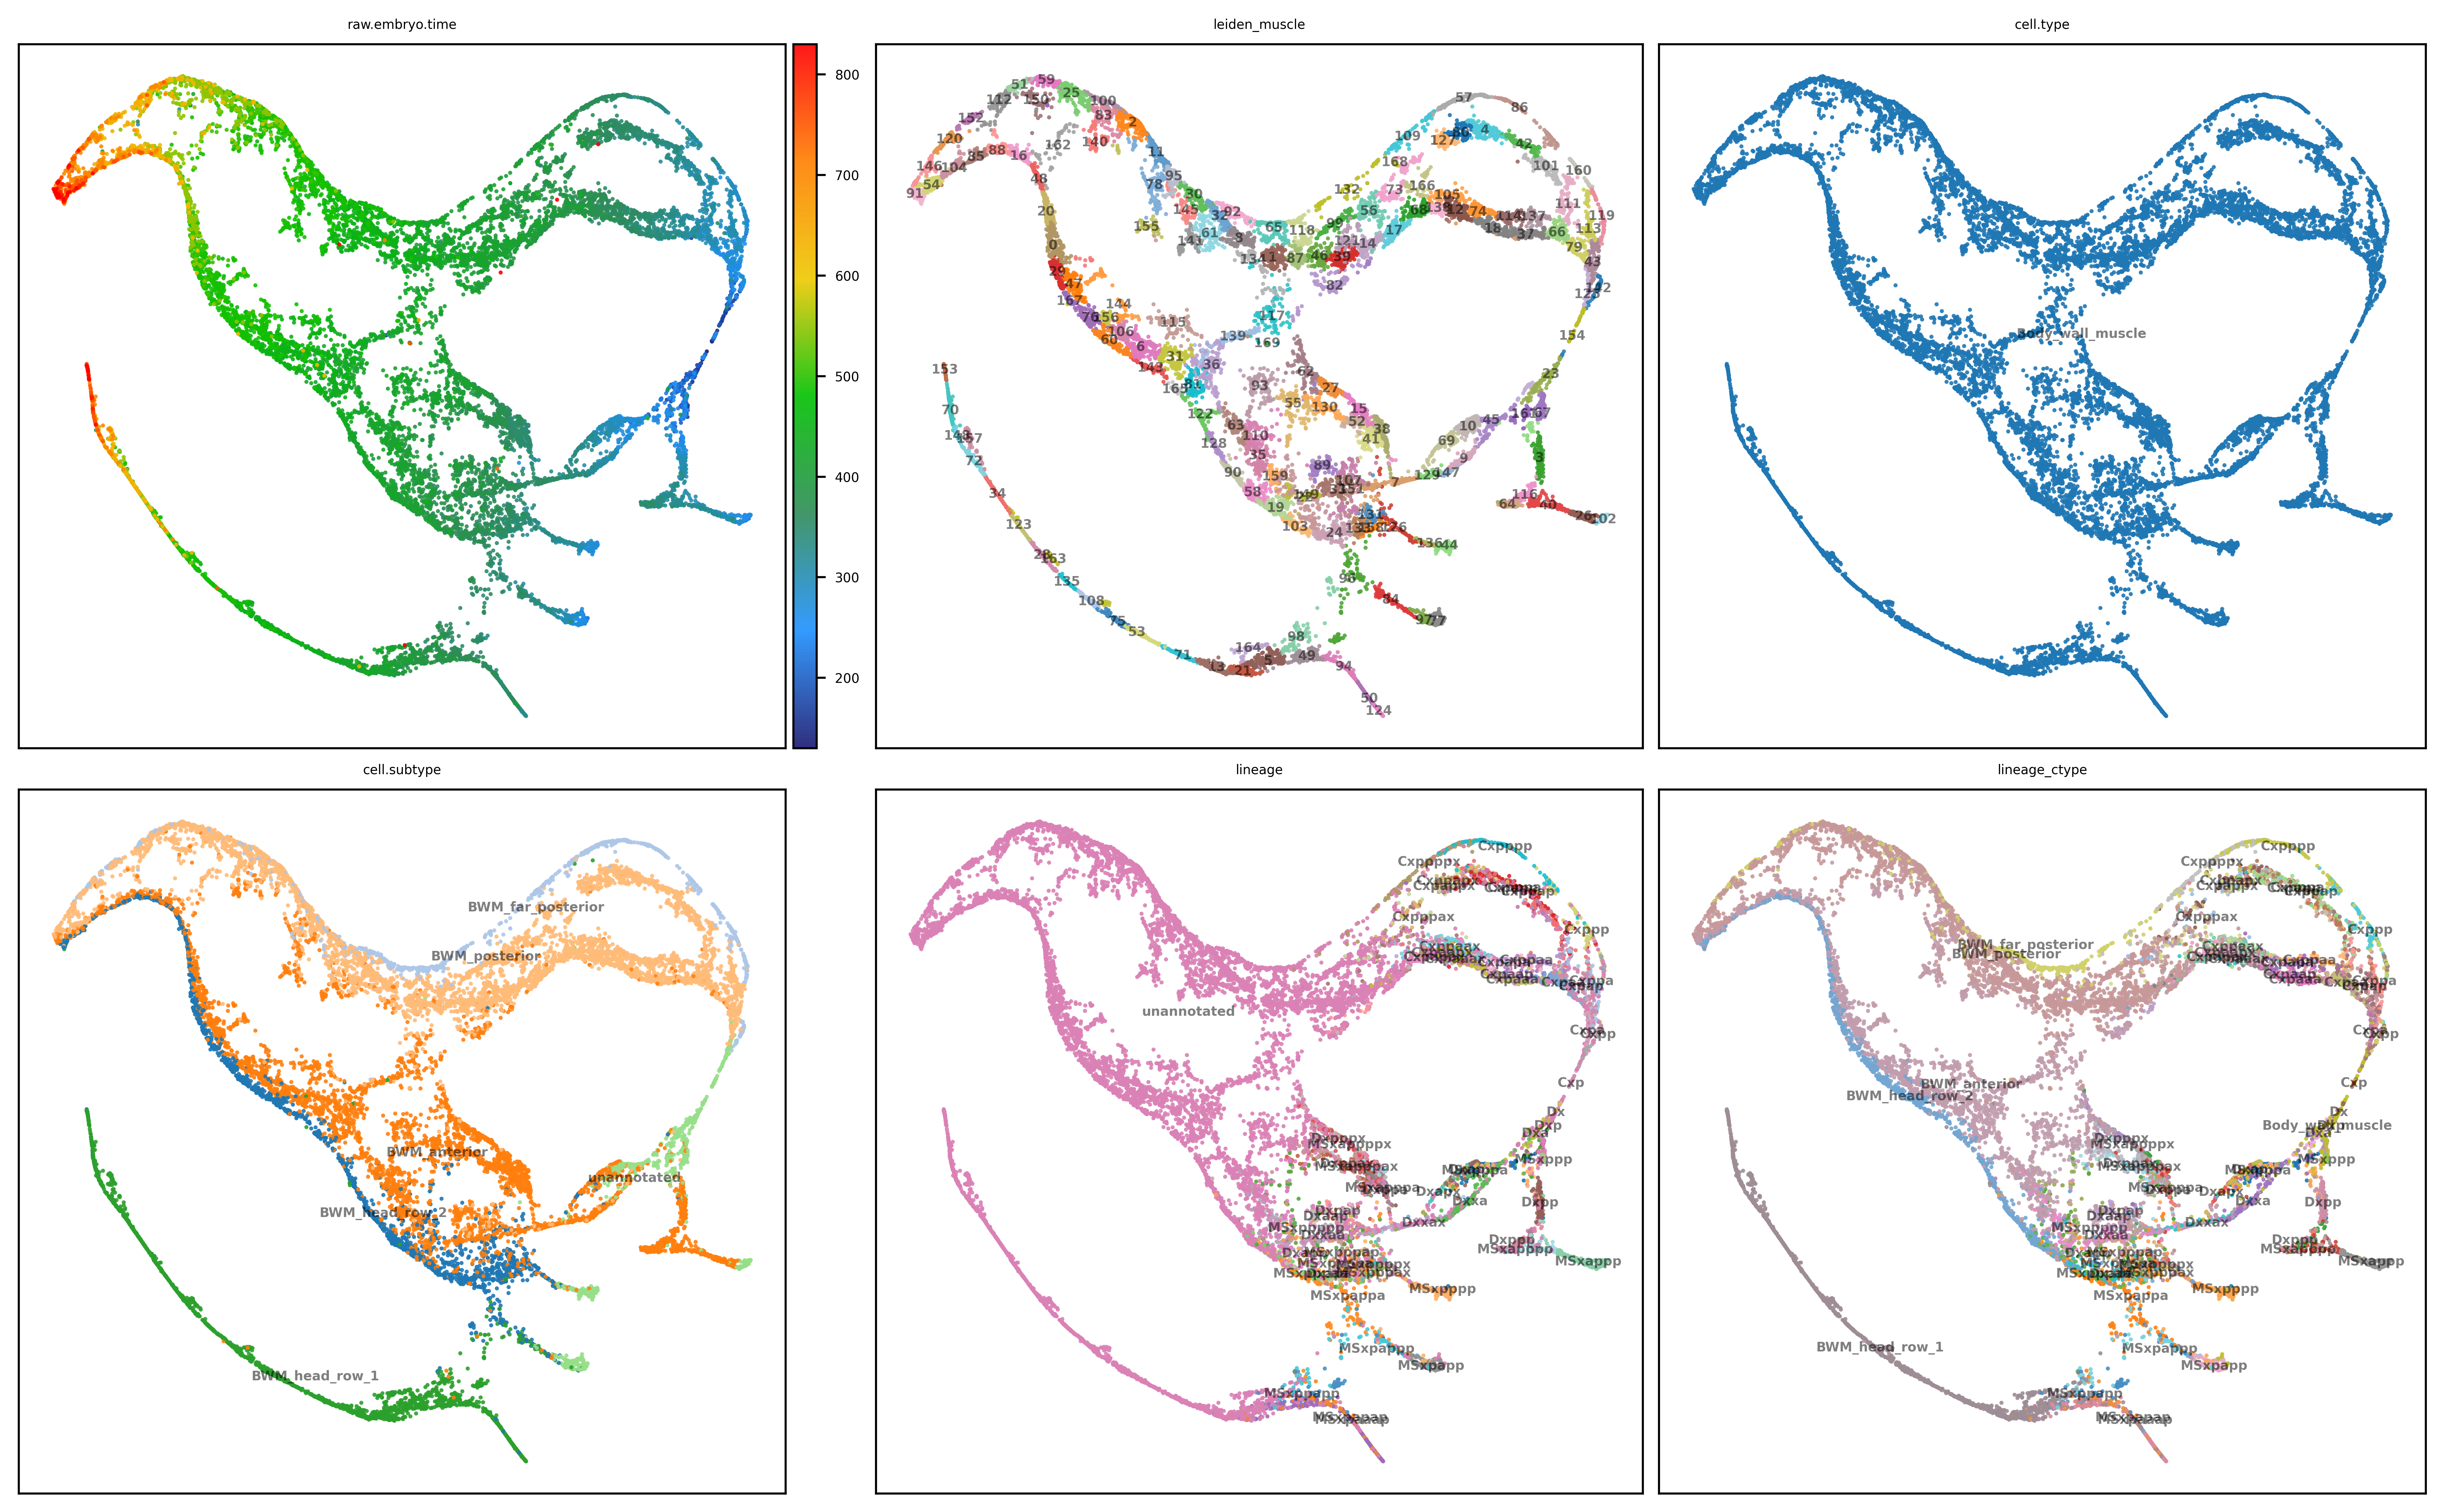

In [40]:
output_key = 'Concord_Dec16-1646'
basis = output_key
ccd.ul.run_umap(adata_sub, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=1)
show_basis = basis + '_UMAP'
show_cols = ['raw.embryo.time', cluster_key, 'cell.type', 'cell.subtype', 'lineage', 'lineage_ctype']
pal = {cluster_key: 'tab20', 'raw.embryo.time': 'BlueGreenRed', "cell.type": 'tab20', 'cell.subtype':'tab20', 'lineage': 'tab20', 'lineage_ctype': 'tab20'}
ccd.pl.plot_embedding(
    adata_sub[~adata_sub.obs['lineage'].isin(rare_lineage)], show_basis, show_cols, figsize=(13,8), dpi=600, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    pal = pal,
    save_path=save_dir / f"{show_basis}_{file_suffix}.svg"
)

In [2]:
ccd.ul.ensure_categorical(adata_sub, cluster_key)
sc.tl.paga(adata_sub, groups=cluster_key)
filtered_graph, pos = ccd.pl.compute_paga_layout(
    adata_sub,
    groupby_key=cluster_key,
    weight_threshold=0.6,
    spring_k=0.02,
    seed=1
)

NameError: name 'ccd' is not defined

In [1]:
meta_key = f'meta_lineage_ctype_{sub_name}'
ccd.ul.compute_meta_attributes(
    adata_sub,
    groupby_key=cluster_key,
    attribute_key='lineage_ctype',
    method='majority_vote',
    meta_label_name=meta_key
)
ccd.pl.plot_paga_custom(
    adata_sub,
    meta_attribute_key=meta_key,
    groupby_key=cluster_key,
    filtered_graph=filtered_graph,
    pos=pos,
    with_labels=True,
    pal={meta_key: 'tab20'},
    figsize=(20,20),
    save_path=save_dir / f"paga_graph_{meta_key}_{file_suffix}.svg"
)

NameError: name 'sub_name' is not defined

In [34]:
# Save adata_sub


(20401, 20222)


In [ ]:

import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import Concord as ccd
import warnings
warnings.filterwarnings('ignore')

print("Import successful")

proj_name = "cbce_1217"
data_dir = Path('../../data/CE_CB/')
save_dir = f"../../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"


adata = sc.read(data_dir / "adata_cbce_Dec17-1824.h5ad")
adata.obsm = ccd.ul.load_obsm_from_hdf5(Path('../../save/dev_cbce_1217-Dec18/') / f"obsm_Dec18-1227.h5")
print("Data loading successful")

file_suffix = f"{time.strftime('%b%d-%H%M')}"

ccd.set_verbose_mode(True)
timer = ccd.ul.Timer()
time_log = {}


# Run methods
feature_list = ccd.ul.select_features(adata, n_top_features=10000, flavor='seurat_v3')
adata = adata[:,feature_list].copy()
output_key = 'Liger'
with timer:
    ccd.ul.run_liger(adata, batch_key="dataset3", count_layer="counts", output_key=output_key, k=30, return_corrected=False)

time_log[output_key] = timer.interval
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{output_key}_{file_suffix}.h5")
    
# Save time_log as well using pickle
import pickle
import pickle
with open(save_dir / f"time_log_{output_key}_{file_suffix}.pkl", 'wb') as f:
    pickle.dump(time_log, f)



